# OpenAI Image Edit API を使用した画像編集ツール

このノートブックは、OpenAIのImage Edit APIを使用して画像を編集するためのインタラクティブなツールを提供します。

<a href="https://colab.research.google.com/github/catnipglitch/google-colab-notebooks-catnip/blob/main/openai/OpenAI_ImageEdit_Example02.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## 機能

*   **画像のアップロード:** オリジナル画像をアップロードできます。
*   **プロンプト入力:** 画像編集のためのプロンプトを入力できます。
*   **画像サイズ、品質、背景の選択:** 生成される画像のサイズ、品質、背景を指定できます。
*   **画像編集と保存:** アップロードした画像とプロンプトに基づいて画像を編集し、Google Driveに保存できます。
*   **APIレスポンスの保存:** APIからのレスポンスはJSONファイルとしてGoogle Driveに保存されます。
*   **料金試算:** 選択された設定に基づいた概算の料金が表示されます。

## 使用方法

1.  OpenAI APIキーを `userdata` に設定します。
2.  ① 入力ファイルの指定: 編集したい画像を指定します。（複数の画像に対応）
3.  ② 画像編集プロンプト: 画像編集のためのプロンプトを入力し、画像サイズ、品質、背景、生成バリエーション数などを設定します。（複数のプロンプトに対応）
4.  ③ 画像生成の実行: 出力先フォルダを指定し、「画像を編集して保存」ボタン（実際にはセルを実行）をクリックして、画像を編集し、Google DriveまたはColab一時フォルダに保存します。

## 注意事項

*   このノートブックは、OpenAIのImage Edit APIを使用するために、`openai` ライブラリがインストールされている必要があります。
*   Google Driveにアクセスするために、Google Colabの認証が必要です。
*   **入力画像は複数指定可能ですが、Image Edit APIは単一の入力画像に対して動作します。** 実際には指定された有効な入力画像それぞれに対し、選択された全ての有効なプロンプトと設定で個別にAPIコールを実行します。
*   料金試算はあくまで概算であり、OpenAIの公式料金とは異なる場合があります。必ずOpenAIの料金ページで最新情報を確認してください。

## 未実装・今後の追加実装予定

*   **レート制限への対応:** 現在、APIのレート制限を考慮した処理間隔の調整は実装されていません。今後の課題です。
*   **マスク機能:** マスク画像を使用した画像編集機能は現在未対応です。今後の実装課題です。

In [2]:
# @title 初期化 {"run":"auto","vertical-output":true}
#@markdown
%%capture

#!pip install Pillow
!pip install openai


from IPython.display import Image as IPyImage, display
from google.colab import files, userdata, drive
#from PIL import Image as PILImage

import io
import os
import base64
import json
import datetime
from pathlib import Path
from openai import OpenAI
import tempfile
#import ipywidgets as widgets



# 一時ディレクトリを作成
temp_dir = tempfile.mkdtemp()




In [3]:
#@title ### OpenAI API接続の準備をするのだ

api_key = userdata.get('OPENAI_API_KEY')

if not api_key:
    print("エラー: OpenAI APIキーが設定されていません。Colabのシークレットに 'OPENAI_API_KEY' を設定してください。")
else:
    try:
        client = OpenAI(api_key=api_key)
        print("OpenAIクライアントの初期化に成功しました。")
    except Exception as e:
        print(f"エラー: OpenAIクライアントの初期化に失敗しました。APIキーを確認してください: {e}")
        client = None # 初期化失敗時はNoneを設定

OpenAIクライアントの初期化に成功しました。


In [4]:
# @title ###  Googleドライブを一度だけマウントするのだ！ {"run":"auto"}
#@markdown
from google.colab import drive   #冒頭で行っておく
drive.flush_and_unmount()


#@markdown **Google Drive マウントフォルダ**
use_google_drive = True  # @param {"type":"boolean"}
google_drive_mount_path = '/content/drive' # @param {"type":"string","placeholder":"/content/drive"}


if use_google_drive:
    print("Google Drive を利用します")
    drive.mount(google_drive_mount_path, force_remount=True)
else:
    print("Google Drive を利用しません")



print("マウント処理終了")



Drive not mounted, so nothing to flush and unmount.
Google Drive を利用します
Mounted at /content/drive
マウント処理終了


In [5]:
# @title 内部処理：入力ファイル読み込み
def read_image_from_filepath(filepath :str="") -> IPyImage | None:
    """
    指定されたファイルパスの画像を表示可能なIPython.display.Imageオブジェクトとして読み込む関数。

    Args:
        filepath (str): 読み込む画像のファイルパス。(デフォルトは空文字列)
        display_width (int): 表示する画像の幅ピクセル。(デフォルトは 400)

    Returns:
        IPython.display.Image or None: 表示可能なIPython Imageオブジェクト、
                                       またはファイルの読み込みに失敗した場合はNone。
    """
    if not os.path.exists(filepath):
        print(f"エラー: ファイル '{filepath}' が見つかりません。")
        return None

    try:
        image = IPyImage(filepath)

        print(f"ファイル '{filepath}' から画像を読み込みました。")
        return image
    except Exception as e:
        print(f"ファイル '{filepath}' の読み込みに失敗しました: {e}")
        return None

def display_image_from_filepath(filepath ,display_width=400) -> str | None:


        image = read_image_from_filepath(filepath)

        if image is None:
            print(f"画像の読み込みに失敗しました。{filepath}")
        else:
            print("画像が利用可能です。")
            display(IPyImage(filename=filepath, width=display_width))

        return filepath



def upload_file() -> tuple[IPyImage | None, str | None]:
    """
    ファイルをアップロードし、IPython.display.Imageオブジェクトとファイルパスを返す関数。

    Returns:
        tuple[IPython.display.Image or None, str or None]:
            (アップロードされた画像のIPython Imageオブジェクト、アップロードされたファイルのパス)
            またはアップロードされなかった場合は (None, None)。
    """

    uploaded = files.upload()

   #アップロードされたファイルを確認
    if len(uploaded) == 0:
        print("ファイルがアップロードされませんでした。")
        # ファイルがアップロードされなかった場合は None と None を返す
        return None, None
    else:
        # アップロードされた最初のファイルの名前を取得
        uploaded_file_name = next(iter(uploaded))
        print(f"アップロードされたファイル: {uploaded_file_name}")

        # read_image_from_filepath を使用して Image オブジェクトを取得
        # read_image_from_filepath 関数内で display も行われる前提
        image = read_image_from_filepath(uploaded_file_name)

        # Image オブジェクトとファイル名をタプルとして返す
        return image, uploaded_file_name


def upload_file_and_display(display_width=400) -> str | None:

    image,uploaded_file_name = upload_file()

    if image is None:
        print("画像の読み込みに失敗しました。")
    else:
        print("画像が利用可能です。")
        display(image, width=display_width)

    return uploaded_file_name





In [6]:
# @title 内部処理：ユニークなファイル名を生成

def generate_unique_filename(output_path: str, total_count: int = 1, current_index: int = 1) -> str:
    """
    指定された出力パスと生成数に基づき、重複しないタイムスタンプベースのファイル名を生成します。

    動作仕様:
    1. 現在のタイムスタンプ (YYYY-MMDD-HHMM-SS 形式) をベース名とします。
    2. total_count が 1 より大きい場合、ファイル名に連番と総数 (`_NNofMM`) を追加します。
    3. 生成されたファイル名 (`.png` および `.json` 拡張子を含む) が output_path に既に存在するかを確認します。
    4. 同名のファイルが存在する場合、ファイル名の末尾に連番サフィックス (`_suffix`) を追加して一意性を確保します。
    5. 最終的に一意性が確認されたファイル名 (拡張子なし) を返します。

    Args:
        output_path (str): ファイルを保存するディレクトリのパス。
        total_count (int): 生成されるファイルの総数 (デフォルトは1)。
        current_index (int): 現在生成中のファイルのインデックス (1からtotal_countまで、デフォルトは1)。

    Returns:
        str: 拡張子を含まない、生成されたユニークなファイル名。
    """
    timestamp = datetime.datetime.now().strftime('%Y-%m%d-%H%M-%S')
    base_filename = timestamp

    # n が 1 以外の場合は連番を追加
    if total_count > 1:
        filename = f"{base_filename}_{current_index:02d}of{total_count:02d}"
    else:
        filename = base_filename

    img_path = os.path.join(output_path, f"{filename}.png")
    json_path = os.path.join(output_path, f"{filename}.json")

#　同名のファイルチェック
    index = 0
    while os.path.exists(img_path) or os.path.exists(json_path):
        index += 1
        # 連番サフィックス付きのファイル名を生成
        filename = f"{base_filename}_{current_index:02d}of{total_count:02d}_{index}" if total_count > 1 else f"{base_filename}_{index}"
        img_path = os.path.join(output_path, f"{filename}.png")
        json_path = os.path.join(output_path, f"{filename}.json")

    return filename

In [7]:
# @title 内部処理：Create Image Edit
def create_image_edit_from_openai(input_image_paths: list[str], output_base_path: str,**kwargs) -> str | None:
    """
    OpenAI Image Edit API を利用して画像を生成し、指定されたパスに保存します。
    生成された画像はColabの出力セルに表示されます。

    動作仕様:
    1. input_image_paths で指定された複数のオリジナル画像ファイルを開きます。
    2. 提供されたプロンプトと画像編集パラメータ (`model`, `size`, `quality`, `n`) を使用して、
       OpenAI Image Edit API (`client.images.edit`) を呼び出します。
       必要に応じてマスク画像も使用できます（現在のコードでは original_image_path のみを使用）。
       （補足：マスク画像を使用する場合、API呼び出し時の kwargs に mask パラメータを追加する必要があります。）
    3. APIからのレスポンスに含まれる各生成画像データ (Base64形式) をデコードします。
    4. デコードされた画像データを `IPython.display.Image` を用いてColabの出力セルに表示します。
    5. 生成された各画像に対し、generate_unique_filename 関数を使用して一意なファイル名を生成します。
    6. 生成された画像 (PNG形式) と、使用した生成パラメータを含むJSONファイルを output_base_path ディレクトリに保存します。
    7. API呼び出しまたは処理中にエラーが発生した場合、エラーメッセージを出力し None を返します。
    8. ファイルは自動的に閉じられます (with open 構文使用を推奨)。

    Args:
        input_image_paths (list[str]): 元となる画像ファイルのパスのリスト。OpenAI Image Edit API に渡されます。
        output_base_path (str): 生成された画像とパラメータを保存するディレクトリのパス。
        prompt (str): 画像編集のためのテキストプロンプト。

    Returns:
        str or None: 処理が成功した場合に保存された画像ファイルのフルパス（最初の画像など）、
                     または生成に失敗した場合は None を返します。
                     （現在の実装では常に None を返します。必要に応じて修正してください。）
    """
    # 画像ファイルを開く (with構文で自動的に閉じられるように変更)
    image_files = []
    try:
        for input_path in input_image_paths:
            if os.path.exists(input_path):
                image_files.append(open(input_path, "rb"))
            else:
                print(f"エラー: 入力ファイル '{input_path}' が見つかりません。このファイルはスキップされます。")

        if not image_files:
            print("エラー: 有効な入力画像ファイルが見つかりませんでした。")
            return None

        kwargs["image"] = image_files

        if client is None:
             print("エラー: OpenAIクライアントが初期化されていません。")
             return None

        result = client.images.edit(**kwargs)

        # レスポンスを確認して画像を表示・保存するのだ！
        # result.data はリストなので、各要素を処理
        for i, image_data in enumerate(result.data):
            # 画像データのデコード
            # Base64デコードに失敗する可能性も考慮してtry-exceptを追加
            try:
                image_bytes = base64.b64decode(image_data.b64_json)
            except (base64.binascii.Error, AttributeError) as e:
                 print(f"エラー: 画像 {i + 1} のBase64デコードに失敗しました: {e}")
                 continue # 次の画像データに進む

            # 画像を表示
            print(f"画像 {i + 1} が生成されたのだ！表示するのだ～！")
            # IPython.display.Image はバイトデータまたはファイルパスを受け取る
            # インポート名を考慮して IPyImage に修正
            display(IPyImage(data=image_bytes, width=400)) # IPython.display.Image は IPyImage と別名でインポートされている前提

            # ユニークなファイル名を生成するのだ
            # generate_unique_filename 関数は output_path, total_count, current_index を引数にとる
            # img_count が画像を生成する数であると仮定し、それを total_count に渡す
            filename = generate_unique_filename(output_base_path, total_count=img_count, current_index=i + 1)

            img_file_path = os.path.join(output_base_path, f"{filename}.png")
            json_file_path = os.path.join(output_base_path, f"{filename}.json")

            # 画像ファイルを保存するのだ (with構文で自動的に閉じられるように変更)
            try:
                with open(img_file_path, 'wb') as img_file:
                    img_file.write(image_bytes)
            except IOError as e:
                 print(f"エラー: 画像ファイル '{img_file_path}' の保存に失敗しました: {e}")
                 # 保存に失敗しても処理を続けるか、ここで終了するかは仕様による
                 continue # 今回は保存に失敗した画像はスキップ

            # 生成パラメータをJSONファイルに保存するのだ
            # kwargs からプロンプトを取得する
            current_prompt = kwargs.get("prompt", "プロンプト情報なし") # kwargsからプロンプトを取得、見つからない場合はデフォルト値を設定

            params = {
                "prompt": current_prompt,  # ここで取得したプロンプトを使用
                "size": kwargs.get("size", "不明"), # kwargsから取得、見つからない場合はデフォルト値を設定
                "quality": kwargs.get("quality", "不明"), # kwargsから取得
                "background": kwargs.get("background", "不明"), # kwargsから取得
                "model": kwargs.get("model", "不明"), # kwargsから取得
                "generation_time": datetime.datetime.now().isoformat(),
                "input_fidelity": kwargs.get("input_fidelity", "不明"), # kwargsから取得
                # usage 情報を含める場合は、APIレスポンスの result.usage を適切に処理して追加
                # 例: if hasattr(result, 'usage') and result.usage: # usage属性が存在しNoneでないか確認
                #         params["usage"] = result.usage.__dict__
            }

            try:
                with open(json_file_path, 'w', encoding='utf-8') as json_file:
                    # JSONシリアライズできないオブジェクトが含まれていないか確認
                    json.dump(params, json_file, ensure_ascii=False, indent=2)
            except (IOError, TypeError) as e:
                 print(f"エラー: パラメータファイル '{json_file_path}' の保存に失敗しました: {e}")
                 # 保存に失敗しても処理を続けるか、ここで終了するかは仕様による
                 pass # パラメータ保存失敗は致命的でないと仮定して続行

            print(f"画像を保存したのだ: {img_file_path}")
            print(f"パラメータも保存したのだ: {json_file_path}")

    except Exception as e: # OpenAI API呼び出し自体で発生する可能性のあるエラーを含む広範な例外捕捉
        # OpenAI APIからの特定のエラーを捕捉するとより良い
        # 例: from openai import APIError
        # except APIError as e:
        #    print(f"OpenAI APIエラー: {e.status_code} - {e.response}")
        # except Exception as e:
        print(f"画像生成処理中に予期せぬエラーが起きてしまいました: {e}")
        return None
    finally:
        # 開いたファイルをすべて閉じる
        for f in image_files:
            f.close()

    # 関数が成功した場合の返り値をここで指定
    # 例: return saved_img_path # 保存した最初の画像のパスなどを返す
    return None # 現在の仕様では明示的な返り値は不要と仮定

In [8]:
# @title 内部処理：画像生成コスト試算関数
def calculate_image_generation_cost(
    model_name: str,
    quality: str,
    size: str,
    num_input_images: int,
    num_prompts: int,
    n_variations: int
) -> tuple[float | str, float | str]:
    """
    指定されたパラメータに基づき、OpenAI画像生成APIの概算コストを計算します。

    Args:
        model_name (str): 使用するモデルの名前 (例: 'gpt-image-1', 'dall-e-2')。
        quality (str): 生成画像の品質 (例: 'high', 'medium', 'low', 'standard')。
        size (str): 生成画像のサイズ (例: '1024x1024', '1536x1024')。
        num_input_images (int): 使用する入力画像の数。
        num_prompts (int): 使用するプロンプトの数。
        n_variations (int): 各API呼び出しで生成される画像のバリエーション数 (nパラメータの値)。

    Returns:
        tuple[float | str, float | str]: (1枚あたりの単価, 合計概算コスト)。
                                          価格が見つからない場合は ('不明', '不明') を返します。
    """
    # モデル、品質、サイズに基づく価格テーブル
    # 最新および正確な料金情報は、必ずOpenAI公式の料金ページをご確認ください。
    # https://platform.openai.com/docs/pricing#image-generation
    price_table = {
        # GPT Image 1.5 の価格
        ('gpt-image-1.5', 'low', '1024x1024'): 0.009,
        ('gpt-image-1.5', 'low', '1024x1536'): 0.013,
        ('gpt-image-1.5', 'low', '1536x1024'): 0.013,
        ('gpt-image-1.5', 'medium', '1024x1024'): 0.034,
        ('gpt-image-1.5', 'medium', '1024x1536'): 0.05,
        ('gpt-image-1.5', 'medium', '1536x1024'): 0.05,
        ('gpt-image-1.5', 'high', '1024x1024'): 0.133,
        ('gpt-image-1.5', 'high', '1024x1536'): 0.2,
        ('gpt-image-1.5', 'high', '1536x1024'): 0.2,

        # GPT Image Latest の価格
        ('gpt-image-latest', 'low', '1024x1024'): 0.009,
        ('gpt-image-latest', 'low', '1024x1536'): 0.013,
        ('gpt-image-latest', 'low', '1536x1024'): 0.013,
        ('gpt-image-latest', 'medium', '1024x1024'): 0.034,
        ('gpt-image-latest', 'medium', '1024x1536'): 0.05,
        ('gpt-image-latest', 'medium', '1536x1024'): 0.05,
        ('gpt-image-latest', 'high', '1024x1024'): 0.133,
        ('gpt-image-latest', 'high', '1024x1536'): 0.2,
        ('gpt-image-latest', 'high', '1536x1024'): 0.2,

        # GPT Image 1 の価格
        ('gpt-image-1', 'low', '1024x1024'): 0.011,
        ('gpt-image-1', 'low', '1024x1536'): 0.016,
        ('gpt-image-1', 'low', '1536x1024'): 0.016,
        ('gpt-image-1', 'medium', '1024x1024'): 0.042,
        ('gpt-image-1', 'medium', '1024x1536'): 0.063,
        ('gpt-image-1', 'medium', '1536x1024'): 0.063,
        ('gpt-image-1', 'high', '1024x1024'): 0.167,
        ('gpt-image-1', 'high', '1024x1536'): 0.250,
        ('gpt-image-1', 'high', '1536x1024'): 0.250,

        # GPT Image 1 Mini の価格
        ('gpt-image-1-mini', 'low', '1024x1024'): 0.005,
        ('gpt-image-1-mini', 'low', '1024x1536'): 0.006,
        ('gpt-image-1-mini', 'low', '1536x1024'): 0.006,
        ('gpt-image-1-mini', 'medium', '1024x1024'): 0.011,
        ('gpt-image-1-mini', 'medium', '1024x1536'): 0.015,
        ('gpt-image-1-mini', 'medium', '1536x1024'): 0.015,
        ('gpt-image-1-mini', 'high', '1024x1024'): 0.036,
        ('gpt-image-1-mini', 'high', '1024x1536'): 0.052,
        ('gpt-image-1-mini', 'high', '1536x1024'): 0.052,

        # DALL-E 2 の価格 (例として追加, Edit APIのDALL-E 2は1024x1024まで)
        # Edit API の DALL-E 2 は 256x256, 512x512, 1024x1024 をサポート
        ('dall-e-2', 'standard', '1024x1024'): 0.020,
        ('dall-e-2', 'standard', '512x512'): 0.018,
        ('dall-e-2', 'standard', '256x256'): 0.016,
        # 将来的に他のモデル（例: Geminiなど）の価格を追加する場合
        # ('gemini-model', 'quality', 'size'): price,
    }

    # 現在の設定に対応する単価を取得
    # キーは小文字に統一して検索
    price_key = (model_name.lower(), quality.lower(), size.lower())
    price_per_image = price_table.get(price_key)

    if price_per_image is None:
        # 価格情報が見つからない場合
        return "不明", "不明"
    else:
        # 合計生成回数を計算: 入力画像数 * プロンプト数 * バリエーション数
        total_generations = num_input_images * num_prompts * n_variations

        # 合計試算金額を計算 (出力画像のみのコスト)
        total_cost_estimate = total_generations * price_per_image

        return price_per_image, total_cost_estimate

# 入力ファイル設定方法は
下記の方法でファイル名指定できるように準備します。

## - Google Driveにアップロードする。
アップロードしてファイルパスを取得します。
## - Colab 一時フォルダ (/content)へアップロードする。
次のブロックでアップロードするか、Colobファイルウインドウの任意のフォルダへアップロードする。


In [9]:
# @title #  準備： Colaboの一時フォルダ(/content)へアップロードする。
#@markdown *Colab でアップロードするとカレントディレクトリである /content配下に作成されます。*
#@markdown *複数のファイルがある場合はアップロードを繰り返してください。表示は上書きされますが、contentフォルダに残ります）

if use_google_drive:

    print(f"入力画像は①入力ファイルフォームへ記載してください")
else:
    # Colobでファイル選択してアップロードします
    tmp_colabo_uploaded_filename = upload_file_and_display();
    if tmp_colabo_uploaded_filename is None:
        print(f"画像の読み込みに失敗しました。:{tmp_colabo_uploaded_filename}")
    else:
        print(f"画像のアップロードできました。ファイルパスを入力ファイル名に入力してください。")
        print(f"{tmp_colabo_uploaded_filename}")

入力画像は①入力ファイルフォームへ記載してください


ファイル '/content/drive/MyDrive/Colab-Sample-Images/woman/woman-portrait.jpg' から画像を読み込みました。
画像が利用可能です。


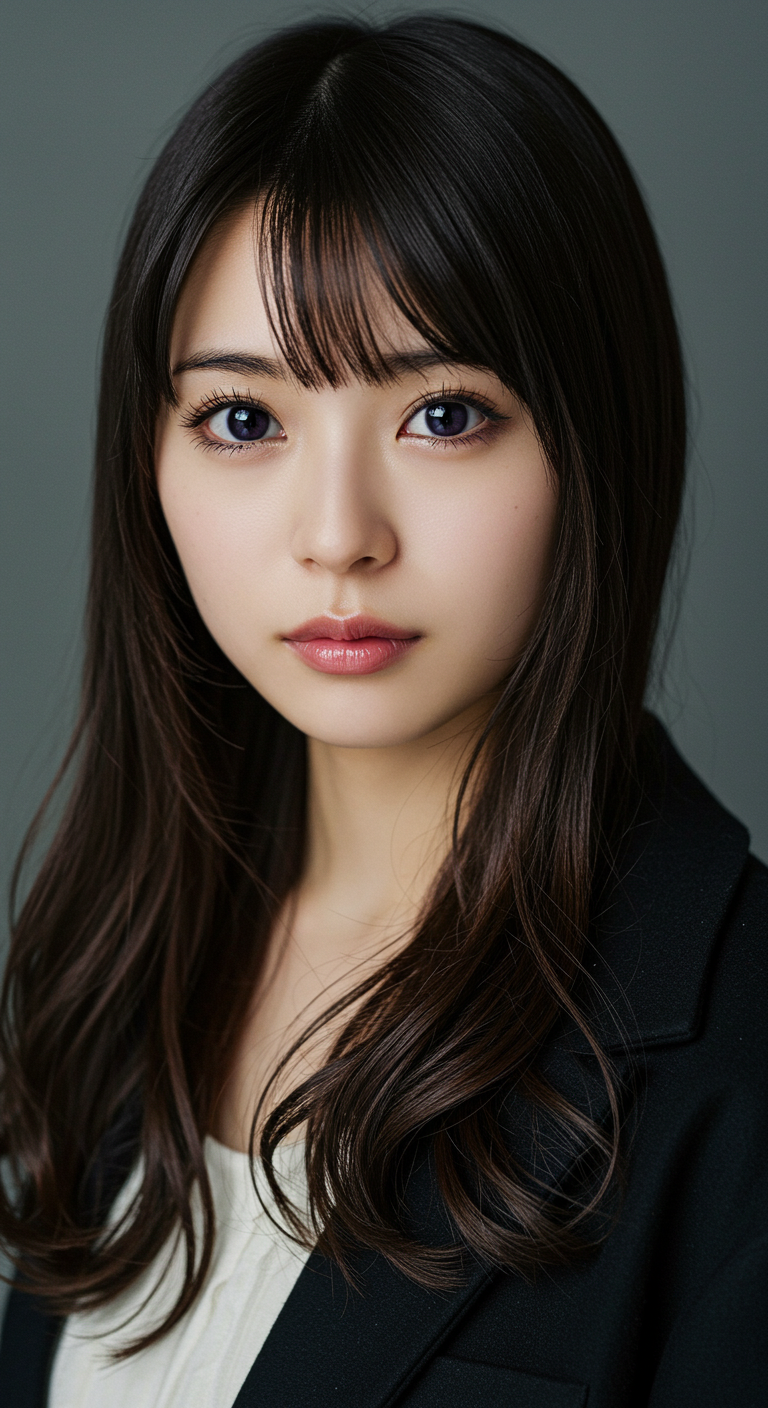


--- Input File Status ---
-----------------------------------
[Processing Target]                 /content/drive/MyDrive/Colab-Sample-Images/woman/woman-portrait.jpg
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
[Skipped: Disabled/Empty]           (Empty)
-----------------------------------

1 file(s) are selected for processing.


In [10]:
# @title ①入力ファイルの指定 {"run":"auto","vertical-output":true}
#@markdown ファイル名のみの場合はカレントディレクトリの **/content配下** のファイルが読まれます

#@markdown **入力ファイル設定**

# 各ファイル名に対応する enabled フラグ
input_filename_00_enabled = True # @param {"type":"boolean"}
input_filename_00 = "/content/drive/MyDrive/Colab-Sample-Images/woman/woman-portrait.jpg" # @param {"type":"string"}

input_filename_01_enabled = False # @param {"type":"boolean"}
input_filename_01 = "" # @param {"type":"string"}

input_filename_02_enabled = False # @param {"type":"boolean"}
input_filename_02 = "" # @param {"type":"string"}

input_filename_03_enabled = False # @param {"type":"boolean"}
input_filename_03 = "" # @param {"type":"string"}

input_filename_04_enabled = False # @param {"type":"boolean"}
input_filename_04 = "" # @param {"type":"string"}

input_filename_05_enabled = False # @param {"type":"boolean"}
input_filename_05 = "" # @param {"type":"string"}

input_filename_06_enabled = False # @param {"type":"boolean"}
input_filename_06 = "" # @param {"type":"string"}

input_filename_07_enabled = False # @param {"type":"boolean"}
input_filename_07 = "" # @param {"type":"string"}

input_filename_08_enabled = False # @param {"type":"boolean"}
input_filename_08 = "" # @param {"type":"string"}

input_filename_09_enabled = False # @param {"type":"boolean"}
input_filename_09 = "" # @param {"type":"string"}

input_filename_10_enabled = False # @param {"type":"boolean"}
input_filename_10 = "" # @param {"type":"string"}

input_filename_11_enabled = False # @param {"type":"boolean"}
input_filename_11 = "" # @param {"type":"string"}

input_filename_12_enabled = False # @param {"type":"boolean"}
input_filename_12 = "" # @param {"type":"string"}

input_filename_13_enabled = False # @param {"type":"boolean"}
input_filename_13 = "" # @param {"type":"string"}

input_filename_14_enabled = False # @param {"type":"boolean"}
input_filename_14 = "" # @param {"type":"string"}

input_filename_15_enabled = False # @param {"type":"boolean"}
input_filename_15 = "" # @param {"type":"string"}


# input_file_limit は削除

# enabled フラグとファイル名をペアにしてリストにまとめる
all_input_files_with_status = [
    (input_filename_00_enabled, input_filename_00),
    (input_filename_01_enabled, input_filename_01),
    (input_filename_02_enabled, input_filename_02),
    (input_filename_03_enabled, input_filename_03),
    (input_filename_04_enabled, input_filename_04),
    (input_filename_05_enabled, input_filename_05),
    (input_filename_06_enabled, input_filename_06),
    (input_filename_07_enabled, input_filename_07),
    (input_filename_08_enabled, input_filename_08),
    (input_filename_09_enabled, input_filename_09),
    (input_filename_10_enabled, input_filename_10),
    (input_filename_11_enabled, input_filename_11),
    (input_filename_12_enabled, input_filename_12),
    (input_filename_13_enabled, input_filename_13),
    (input_filename_14_enabled, input_filename_14),
    (input_filename_15_enabled, input_filename_15),
]

valid_input_filenames = []    # 処理対象となる、Enabledかつ存在し、ファイル名が入力されているファイルリスト
file_statuses = []            # 全てのファイルのステータスとファイル名を記録

for enabled, filename in all_input_files_with_status:
    status = ""
    display_filename = filename.strip() if filename.strip() else "(Empty)"

    if filename.strip(): # ファイル名が入力されている場合のみチェック
        if enabled:
            if os.path.exists(filename):
                status = "[Processing Target]" # 処理対象
                valid_input_filenames.append(filename)
                display_image_from_filepath(filename,64)    #ファイルを読み込んでdisplay
            else:
                status = "[Error: File Not Found]" # 有効化されているがファイルなし
        else: # enabled が False
            if os.path.exists(filename):
                 status = "[Skipped: Disabled]" # 無効化されているがファイルあり
            else:
                 status = "[Skipped: Disabled/File Not Found]" # 無効化されておりファイルなし
    else: # ファイル名が入力されていない場合
        if enabled:
            status = "[Skipped: Enabled/Empty]" # 有効化されているがファイル名なし
        else:
            status = "[Skipped: Disabled/Empty]" # 無効化されておりファイル名なし (デフォルト状態)

    file_statuses.append((status, display_filename))


# 結果を一覧で出力
print("\n--- Input File Status ---")
print("-" * 35) # 区切り線を調整

# ステータスとファイル名を表示
for status, filename in file_statuses:
    print(f"{status: <35} {filename}") # ステータス表示幅を固定して揃える

print("-" * 35)


# 後続の処理で valid_input_filenames を使用する (これは実際に処理されるファイルリスト)

if not valid_input_filenames:
    print("\nError: No input files selected for processing. Please ensure 'Enabled' is checked and a valid file path is provided for at least one file.")
else:
     print(f"\n{len(valid_input_filenames)} file(s) are selected for processing.")



In [13]:
# @title ②画像編集プロンプト {"run":"auto","vertical-output":true}

#@markdown ## *下記のプロンプトは個別に適応されます。*

#@markdown **プロンプト情報**
prompt_01_enabled = True # @param {"type":"boolean"}
prompt_01 = "Transform this image of this subject into a cyberpunk aesthetic neon lights, dark city backdrop, glowing signs, misty rain, and futuristic accessories. Add moody shadows and light reflections on metallic surfaces." # @param {type:"string"}
prompt_02_enabled = True # @param {"type":"boolean"}
prompt_02 = "Convert this image of Japanese actress into a 3D Pixar-style cartoon clean lines, soft lighting, expressive features, and a polished render that feels cinematic." # @param {type:"string"}
prompt_03_enabled = True # @param {"type":"boolean"}
prompt_03 = "Remix this photo into a Studio Ghibli-style illustration — soft watercolor palette, delicate linework, cozy atmosphere, and fantasy elements like floating lights or magical plants." # @param {type:"string"}
prompt_04_enabled = True # @param {"type":"boolean"}
prompt_04 = "Apply an oil painting effect to this image visible brush strokes, textured canvas feel, rich color layers, and Rembrandt-inspired lighting." # @param {type:"string"}
prompt_05_enabled = True # @param {"type":"boolean"}
prompt_05 = "Design a luxury magazine cover using this image of [your subject here]. Include elegant typography, barcode, cover lines, and white space margin layout inspired by Vogue or Forbes." # @param {type:"string"}
prompt_06_enabled = True # @param {"type":"boolean"}
prompt_06 = "Remix this into a surreal dreamscape soft haze, levitating objects, bending background, and unnatural light sources. Keep a pastel-toned atmosphere." # @param {type:"string"}
prompt_07_enabled = True # @param {"type":"boolean"}
prompt_07 = "Stylize this image like an anime still bold linework, cel shading, speed lines in the background, and optional Japanese text or subtitle at the bottom." # @param {type:"string"}
prompt_08_enabled = True # @param {"type":"boolean"}
prompt_08 = "Transform this into a classic noir scene high-contrast black and white, sharp shadows, foggy ambiance, and vintage film grain." # @param {type:"string"}
prompt_09_enabled = True # @param {"type":"boolean"}
prompt_09 = "Make this image look like a marble sculpture grayscale tone, chiseled features, and museum-style spotlighting. Optional: pedestal base." # @param {type:"string"}
prompt_10_enabled = True # @param {"type":"boolean"}
prompt_10 = "Elevate this image to a high-fashion editorial spread glossy texture, cinematic color grading, luxury setting, and softbox-style lighting." # @param {type:"string"}
prompt_11_enabled = True # @param {"type":"boolean"}
prompt_11 = "Apply golden hour tones to this image warm sunlight, soft highlights, long shadows, and dreamy golden hues." # @param {type:"string"}
prompt_12_enabled = True # @param {"type":"boolean"}
prompt_12 = "Turn this into glitch art RGB channel split, digital distortion, pixel drag, VHS noise, and futuristic UI elements." # @param {type:"string"}


#@markdown ##*1画像でいくつのバリエーションを生成するか。
img_count = 1 # @param {"type":"slider","min":1,"max":16,"step":1}
#@markdown ### 最終的に生成される画像は (有効なプロンプト数) x img_count となります。**料金に注意**


img_size = '1024x1536' # @param ["1024x1024", "1536x1024", "1024x1536"]
img_quality = 'high' # @param ["high", "medium","low"]
img_input_fidelity = 'high' # @param ["high", "medium","low"]
img_background = 'opaque' # @param ["transparent", "opaque"]

# モデル選択を追加 (計算関数と合わせるため)
model_name = "gpt-image-1.5" # @param ["gpt-image-1","gpt-image-1.5","gpt-image-latest","gpt-image-1-mini"]


# プロンプトをリストにまとめる（有効化されたもののみ）
all_prompts_with_status = [
    (prompt_01_enabled, prompt_01),
    (prompt_02_enabled, prompt_02),
    (prompt_03_enabled, prompt_03),
    (prompt_04_enabled, prompt_04),
    (prompt_05_enabled, prompt_05),
    (prompt_06_enabled, prompt_06),
    (prompt_07_enabled, prompt_07),
    (prompt_08_enabled, prompt_08),
    (prompt_09_enabled, prompt_09),
    (prompt_10_enabled, prompt_10),
    (prompt_11_enabled, prompt_11),
    (prompt_12_enabled, prompt_12),
]

# enabled が True で、かつプロンプトテキストが空でないもののみを抽出
used_prompts = [p for enabled, p in all_prompts_with_status if enabled and p.strip()]


print(f"\n--- 利用されるプロンプトリスト ---")
print(f"利用されるプロンプト数: {len(used_prompts)}")
for i, p in enumerate(used_prompts):
    print(f"  {i + 1}: {p}")
print(f"-----------------------------\n")


# --- 料金試算部分をここに追加 ---

# valid_input_filenames が定義されているか確認
# 実行前に①入力ファイル指定のセルを実行しておく必要がある
if 'valid_input_filenames' not in locals():
    print("警告: ①入力ファイル指定のセルが実行されていません。正確な試算のために、先にそのセルを実行してください。")
    num_input_files = 0 # 未実行の場合は入力ファイル数不明として計算
elif valid_input_filenames:
    num_input_files = len(valid_input_filenames)
else:
    num_input_files = 0

# 使用するプロンプト数とバリエーション数を取得
num_used_prompts = len(used_prompts)
num_variations_per_call = img_count # n の値

# 定義した関数を使ってコストを試算
# calculate_image_generation_cost 関数が定義されている前提です。
# このセルを実行する前に、calculate_image_generation_cost 関数を含むセルも実行してください。
if 'calculate_image_generation_cost' in globals() and num_input_files > 0 and num_used_prompts > 0:
    price_per_image, total_cost_estimate = calculate_image_generation_cost(
        model_name,
        img_quality,
        img_size,
        num_input_files,
        num_used_prompts,
        num_variations_per_call
    )

    # 合計生成回数を計算
    total_generations = num_input_files * num_used_prompts * num_variations_per_call


    print(f"\n--- 試算情報 ---")
    print(f"使用モデル: {model_name}")
    print(f"品質: {img_quality}")
    print(f"サイズ: {img_size}")
    print(f"有効な入力ファイル数: {num_input_files}")
    print(f"利用されるプロンプト数: {num_used_prompts}")
    print(f"1入力ファイル/1プロンプトあたりの生成画像数 (n): {num_variations_per_call}")
    print(f"合計画像生成回数 (予定): {total_generations} 回")

    if isinstance(price_per_image, float): # 価格が数値（float）の場合
         print(f"1画像あたりの概算コスト ({img_size}, {img_quality}): ${price_per_image:.3f}")
         print(f"合計概算コスト (出力画像のみ): ${total_cost_estimate:.2f}")
         print("※ 上記は出力画像トークンコストのみの試算です。OpenAI公式料金ページで最新の情報を確認してください。")
         print("※ 入力画像のトークンコストは含まれていません。") # Image Edit API は入力画像にもコストがかかる場合があるため追記 [1]
    else: # 価格が '不明' の場合
        print(f"合計概算コスト: {total_cost_estimate} (指定されたモデル/品質/サイズの組み合わせの価格情報がありません)")

    print(f"---------------")
else:
    # calculate_image_generation_cost 関数が未定義、または入力ファイル/プロンプトがない場合
    if 'calculate_image_generation_cost' not in globals():
         print("警告: calculate_image_generation_cost 関数が定義されていません。試算を表示できません。")
    elif num_input_files == 0:
         print("警告: 有効な入力ファイルが指定されていません。試算を表示できません。")
    elif num_used_prompts == 0:
         print("警告: 利用されるプロンプトがありません。試算を表示できません。")

# --- 料金試算部分ここまで ---


# 現時点の試算金額を表示 (金額テーブルは後で追加)
# 試算の基本的なロジック: (入力ファイル数) x (利用プロンプト数) x (画像生成数)
# 金額計算には、画像サイズ、品質、モデルも影響しますが、
# ここでは単純な生成数ベースの試算のみ表示します。
# input_file_limit は別のセルで定義されているため、そのセルの実行後にこのセルを実行する必要があります。
# または、input_file_limit をこのセルで定義し直す必要があります。
# 仮に input_file_limit が利用可能と仮定して計算します。

# input_file_limit が利用できない場合は、仮の値などを設定する必要があります。
# 例: if 'input_file_limit' not in locals(): input_file_limit = 1

# 実際に処理される合計画像生成回数を計算
# total_generations = len(valid_input_filenames) * len(used_prompts) * img_count # <-- この行は試算部分に移動したので不要

# print(f"--- 試算情報 ---") # <-- このブロック全体が試算部分に移動したので不要
# print(f"有効な入力ファイル数: {len(valid_input_filenames)}")
# print(f"利用されるプロンプト数: {len(used_prompts)}")
# print(f"1プロンプトあたりの生成画像数 (n): {img_count}")
# print(f"合計画像生成回数: {total_generations} 回")
# print(f"試算金額: 金額テーブルが追加された後に計算されます。")
# print(f"---------------")


--- 利用されるプロンプトリスト ---
利用されるプロンプト数: 12
  1: Transform this image of this subject into a cyberpunk aesthetic neon lights, dark city backdrop, glowing signs, misty rain, and futuristic accessories. Add moody shadows and light reflections on metallic surfaces.
  2: Convert this image of Japanese actress into a 3D Pixar-style cartoon clean lines, soft lighting, expressive features, and a polished render that feels cinematic.
  3: Remix this photo into a Studio Ghibli-style illustration — soft watercolor palette, delicate linework, cozy atmosphere, and fantasy elements like floating lights or magical plants.
  4: Apply an oil painting effect to this image visible brush strokes, textured canvas feel, rich color layers, and Rembrandt-inspired lighting.
  5: Design a luxury magazine cover using this image of [your subject here]. Include elegant typography, barcode, cover lines, and white space margin layout inspired by Vogue or Forbes.
  6: Remix this into a surreal dreamscape soft haze, levit

In [14]:
# @title ③画像生成の実行 {"run":"auto"}

#@markdown ---
#@markdown **出力ファイル設定**
output_fileio = "Google Drive " # @param ["Google Drive ","Colab Temp File"]

output_googledrive_folderpath = '/content/drive/MyDrive/AI_Generated_Images' # @param {type:"string"}
output_Colab_folderpath = '/content/temp_AI_Generated_Images' # @param {type:"string"}

output_subfolder = "woman-portrait" # @param {"type":"string"}
num_of_thread = 1 # @param {"type":"slider","min":1,"max":8,"step":1}
#@markdown ***IPM (Images Per Minute)***
IPM = 5 # @param ["5","20","50","150","250"] {"type":"raw"}


# 最後に生成完了してから開けるべき間隔秒数

interval_time = 60 / IPM

# 1.5秒以下は全部2秒
if interval_time < 1.9:
    interval_time =2

wait_time = 0


# フォルダが無ければ作るよ
os.makedirs(output_googledrive_folderpath , exist_ok=True)
os.makedirs(output_Colab_folderpath , exist_ok=True)




# フォルダパス処理
# subfolder の先頭と末尾のスラッシュを削除
cleaned_output_subfolder = output_subfolder.strip('/')

#ファイルパスを合成
if output_fileio == "Colab Temp File":
    output_base_path = os.path.join(output_Colab_folderpath, cleaned_output_subfolder)
else:
    output_base_path = os.path.join(output_googledrive_folderpath, cleaned_output_subfolder)


# フォルダが無ければ作るよ
os.makedirs(output_base_path , exist_ok=True)

# 使用するモデル名はプロンプト設定セルで定義されているものを使用
# model_name はプロンプト設定セルから取得されることを想定

# Check if necessary variables are defined and valid before proceeding
if 'valid_input_filenames' not in locals() or not valid_input_filenames:
    print("エラー: 有効な入力ファイルが指定されていません。①入力ファイル指定のセルを実行してください。")
elif 'used_prompts' not in locals() or not used_prompts:
     print("エラー: 有効なプロンプトが指定されていません。②画像編集プロンプトのセルを実行してください。")
elif client is None:
     print("エラー: OpenAIクライアントが初期化されていません。初期化セルを実行してください。")
elif 'model_name' not in locals() or model_name not in ['gpt-image-1', 'gpt-image-1.5', 'gpt-image-latest', 'gpt-image-1-mini', 'dall-e-2']:
     # model_name が定義されていない場合も考慮
     print(f"エラー: 指定されたモデル '{model_name if 'model_name' in locals() else '未指定'}' は Image Edit API でサポートされていません。②画像編集プロンプトのセルで 'gpt-image-1' または 'dall-e-2' を選択してください。")
elif 'img_count' not in locals() or img_count < 1:
     print(f"エラー: 生成するバリエーション数 (img_count) が無効です。②画像編集プロンプトのセルで適切な値を指定してください。")
# calculate_image_generation_cost が定義されているかは必須ではないためチェックを削除
else:
    # すべての準備が整った場合のみ続行

    # 試算情報の表示（プロンプト設定セルに移動済みですが、実行前に改めて表示しても良い）
    # もしここに試算情報を表示したい場合は、以前のコードを貼り付けてください。
    # 現在はプロンプト設定セルで表示される前提とします。


    # API呼び出しに必要な共通の引数を準備
    # prompt はループ内で個別に渡すため、ここでは含めない
    kwargs = {
        "model": model_name,  # モデルを指定
        "size": img_size,
        "quality": img_quality,
        "background": img_background,
        "input_fidelity":img_input_fidelity,
        "n": img_count,
    }

    print(f"出力先パス: {output_base_path}\n")

    print(f"\n--- 画像生成処理を開始します ---")
    # 実際に処理される合計回数を計算（プログレス表示用）
    total_operations = len(valid_input_filenames) * len(used_prompts)
    processed_count = 0

    # 入力ファイルとプロンプトの組み合わせでループ
    for input_file_index, input_filename in enumerate(valid_input_filenames):
        # create_image_edit_from_openai 関数は input_image_paths (list) を受け取るため、
        # 現在の入力ファイルパスをリストとして渡します。
        current_input_filepath_list = [input_filename]

        for prompt_index, current_prompt in enumerate(used_prompts):
            processed_count += 1
            # プログレス表示
            print(f"[{processed_count}/{total_operations}] 処理中 -> 入力ファイル: {os.path.basename(input_filename)} , プロンプト: \"{current_prompt[:50]}...\"")

            # API呼び出しに必要な引数を準備（プロンプトを追加）
            call_kwargs = kwargs.copy()
            call_kwargs["prompt"] = current_prompt

            # Image Edit ファイルリスト等を渡して画像生成を実行
            # create_image_edit_from_openai 関数内で API 呼び出し、表示、保存が行われます。
            create_image_edit_from_openai(current_input_filepath_list, output_base_path, **call_kwargs)

            # 必要に応じて待機時間を挿入 (wait_time は現在 0 なので実質待ちません)
            if wait_time > 0:
                 # time モジュールがまだインポートされていない場合に備えてインポート
                 import time
                 print(f"次の生成処理まで {wait_time} 秒待機します...")
                 time.sleep(wait_time)

    print("\n--- 画像生成が完了しました ---")

Output hidden; open in https://colab.research.google.com to view.

# 資料
## OpenAI Image Edit API - Request Body

このエンドポイントは、1つ以上のソース画像とプロンプトに基づいて、編集または拡張された画像を作成します。gpt-image-1とdall-e-2のみをサポートしています。

### パラメータ

| パラメータ | タイプ | 説明 | 必須 |
|---|---|---|---|
| `image` | string or array | 編集する画像。サポートされている画像ファイルまたは画像の配列である必要があります。gpt-image-1の場合、各画像は25MB未満のpng、webp、またはjpgファイルである必要があります。最大16枚の画像を提供できます。dall-e-2の場合、提供できる画像は1枚だけで、4MB未満の正方形のpngファイルである必要があります。 | **必須** |
| `prompt` | string | 目的の画像のテキストによる説明。dall-e-2の最大長は1000文字、gpt-image-1の最大長は32000文字です。 | **必須** |
| `background` | string or null | 生成される画像の背景の透明度を設定できます。このパラメータは、gpt-image-1でのみサポートされています。transparent、opaque、またはauto（デフォルト値）のいずれかである必要があります。autoを使用すると、モデルは画像に最適な背景を自動的に決定します。transparentの場合、出力形式は透明度をサポートする必要があるため、png（デフォルト値）またはwebpに設定する必要があります。 | オプション |
| `mask` | file | imageが編集される場所を示す、完全に透明な領域（アルファがゼロの場所など）を持つ追加の画像。複数の画像が提供されている場合、マスクは最初の画像に適用されます。有効なPNGファイルで、4MB未満で、imageと同じ寸法である必要があります。 | オプション |
| `model` | string | 画像生成に使用するモデル。dall-e-2とgpt-image-1のみがサポートされています。gpt-image-1に固有のパラメータが使用されない限り、デフォルトはdall-e-2です。 | オプション |
| `n` | integer or null | 生成する画像の数。1から10の間である必要があります。 | オプション |
| `quality` | string or null | 生成される画像の品質。high、medium、lowはgpt-image-1でのみサポートされています。dall-e-2は標準品質のみをサポートしています。デフォルトはautoです。 | オプション |
| `response_format` | string or null | 生成された画像が返される形式。urlまたはb64_jsonのいずれかである必要があります。URLは、画像が生成されてから60分間のみ有効です。gpt-image-1は常にbase64エンコードされた画像を返すため、このパラメータはdall-e-2でのみサポートされています。 | オプション |
| `size` | string or null | 生成される画像のサイズ。gpt-image-1の場合は1024x1024、1536x1024（横長）、1024x1536（縦長）、またはauto（デフォルト値）のいずれか、dall-e-2の場合は256x256、512x512、または1024x1024のいずれかである必要があります。 | オプション |
| `user` | string | エンドユーザーを表す一意の識別子。OpenAIが不正使用を監視および検出するのに役立ちます。 | オプション |


### 戻り値

画像オブジェクトのリストを返します。

## GPT-Image 1.5 / 1.0 資料

### 参考料金表

以下の料金は、OpenAI Image Edit API (GPT Image 1) を使用して画像を生成する際の**出力画像トークンコストのみ**を示します。

**注意:**

*   この情報は参考用です。**最新および正確な料金情報は、必ずOpenAI公式の料金ページをご確認ください。**
    [OpenAI 料金ページ](https://platform.openai.com/docs/pricing#image-generation)
*   APIの利用には、他にも関連するコスト（入力トークンなど）が発生する場合がありますが、この表には含まれていません。   |



### Pricing
<table style="border-collapse: collapse; width: 100%;">
  <thead>
    <tr>
      <th style="text-align:left; padding:6px; border-bottom:1px solid #666;">Model</th>
      <th style="text-align:left; padding:6px; border-bottom:1px solid #666;">Quality</th>
      <th style="text-align:right; padding:6px; border-bottom:1px solid #666;">1024x1024</th>
      <th style="text-align:right; padding:6px; border-bottom:1px solid #666;">1024x1536</th>
      <th style="text-align:right; padding:6px; border-bottom:1px solid #666;">1536x1024</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>GPT Image 1.5</td><td>Low</td>
      <td style="text-align:right;">$0.009</td>
      <td style="text-align:right;">$0.013</td>
      <td style="text-align:right;">$0.013</td>
    </tr>
    <tr>
      <td>GPT Image 1.5</td><td>Medium</td>
      <td style="text-align:right;">$0.034</td>
      <td style="text-align:right;">$0.05</td>
      <td style="text-align:right;">$0.05</td>
    </tr>
    <tr>
      <td>GPT Image 1.5</td><td>High</td>
      <td style="text-align:right;">$0.133</td>
      <td style="text-align:right;">$0.2</td>
      <td style="text-align:right;">$0.2</td>
    </tr>
    <tr>
      <td>GPT Image Latest</td><td>Low</td>
      <td style="text-align:right;">$0.009</td>
      <td style="text-align:right;">$0.013</td>
      <td style="text-align:right;">$0.013</td>
    </tr>
    <tr>
      <td>GPT Image Latest</td><td>Medium</td>
      <td style="text-align:right;">$0.034</td>
      <td style="text-align:right;">$0.05</td>
      <td style="text-align:right;">$0.05</td>
    </tr>
    <tr>
      <td>GPT Image Latest</td><td>High</td>
      <td style="text-align:right;">$0.133</td>
      <td style="text-align:right;">$0.2</td>
      <td style="text-align:right;">$0.2</td>
    </tr>
    <tr>
      <td>GPT Image 1</td><td>Low</td>
      <td style="text-align:right;">$0.011</td>
      <td style="text-align:right;">$0.016</td>
      <td style="text-align:right;">$0.016</td>
    </tr>
    <tr>
      <td>GPT Image 1</td><td>Medium</td>
      <td style="text-align:right;">$0.042</td>
      <td style="text-align:right;">$0.063</td>
      <td style="text-align:right;">$0.063</td>
    </tr>
    <tr>
      <td>GPT Image 1</td><td>High</td>
      <td style="text-align:right;">$0.167</td>
      <td style="text-align:right;">$0.25</td>
      <td style="text-align:right;">$0.25</td>
    </tr>
    <tr>
      <td>GPT Image 1 Mini</td><td>Low</td>
      <td style="text-align:right;">$0.005</td>
      <td style="text-align:right;">$0.006</td>
      <td style="text-align:right;">$0.006</td>
    </tr>
    <tr>
      <td>GPT Image 1 Mini</td><td>Medium</td>
      <td style="text-align:right;">$0.011</td>
      <td style="text-align:right;">$0.015</td>
      <td style="text-align:right;">$0.015</td>
    </tr>
    <tr>
      <td>GPT Image 1 Mini</td><td>High</td>
      <td style="text-align:right;">$0.036</td>
      <td style="text-align:right;">$0.052</td>
      <td style="text-align:right;">$0.052</td>
    </tr>
  </tbody>
</table>

<p style="margin-top:8px; font-size:90%;">
※ 料金は1枚の画像生成あたりの概算です。
</p>

### Rate limits
https://platform.openai.com/docs/models/gpt-image-1
https://platform.openai.com/docs/models/gpt-image-1.5

OpenAI APIのレート制限は、特定の期間内に許可されるリクエスト数またはトークン使用量に上限を設けることで、公平で信頼性の高いAPIアクセスを保証します。
使用量に応じたティアによってこれらの上限が設定され、APIへのリクエスト数や利用料金が増加するにつれて自動的に引き上げられます。

| Tier   | TPM (Tokens Per Minute) | IPM (Images Per Minute) |
|--------|-------------------------|-------------------------|
| Free   | Not supported           |                         |
| Tier 1 | 100,000                 | 5                       |
| Tier 2 | 250,000                 | 20                      |
| Tier 3 | 800,000                 | 50                      |
| Tier 4 | 3,000,000               | 150                     |
| Tier 5 | 8,000,000               | 250                     |

※ TPM: 1分あたりのトークン数、IPM: 1分あたりの画像数

## プロンプト資料

### 12種類の人気の画像編集プロンプト（日本語版）

これらのプロンプトは、@godofprompt 氏のバイラル投稿から直接引用し、翻訳したものです。
元の投稿はこちら: https://x.com/godofprompt/status/1921117859092328685

る12種類の人気の画像編集プロンプト

1.  **サイバーパンク風変身**
    「被写体の画像を、サイバーパンク風のネオンライト、暗い街並み、光る看板、霧雨、未来的なアクセサリーでサイバーパンクな美学に変身させてください。メタリックな表面にムーディーな影と光の反射を追加してください。」

2.  **カートゥーン化**
    「[あなたの被写体] の画像を、クリーンなライン、柔らかな照明、表情豊かな特徴、そして映画のような洗練されたレンダリングを備えた3Dピクサー風カートゥーンに変換してください。」

3.  **ジブリ風メイクオーバー**
    「この写真をスタジオジブリ風のイラストにリミックスしてください。柔らかな水彩パレット、繊細な線画、居心地の良い雰囲気、そして浮遊する光や魔法の植物のようなファンタジー要素を加えてください。」

4.  **油絵フィルター**
    「この画像に油絵効果を適用してください。目に見える筆跡、テクスチャのあるキャンバス感、豊かな色の層、そしてレンブラントにインスパイアされた照明を加えてください。」

5.  **雑誌カバー編集**
    「[あなたの被写体] の画像を使用して、高級雑誌のカバーをデザインしてください。エレガントなタイポグラフィ、バーコード、見出し、そしてVogueやForbesにインスパイアされたホワイトスペース余白レイアウトを含めてください。」

6.  **超現実的な夢フィルター**
    「これを超現実的な夢の風景にリミックスしてください。柔らかな霞、浮遊するオブジェクト、歪んだ背景、そして不自然な光源を含めてください。パステル調の雰囲気を維持してください。」

7.  **アニメシーンオーバーレイ**
    「この画像をアニメの静止画のようにスタイル化してください。大胆な線画、セルシェーディング、背景のスピードライン、そしてオプションで下部に日本語のテキストや字幕を加えてください。」

8.  **ノワール照明処理**
    「これをクラシックなノワールシーンに変身させてください。高コントラストの白黒、鋭い影、霧の雰囲気、そしてヴィンテージフィルムグレインを加えてください。」

9.  **3D彫刻風の外観**
    「この画像を大理石の彫刻のように見せてください。グレースケールトーン、彫刻された特徴、そして美術館スタイルのスポットライトを加えてください。オプション: 台座。」

10. **ハイファッション編集**
    「この画像をハイファッションの編集スプレッドに格上げしてください。光沢のあるテクスチャ、映画のようなカラーグレーディング、豪華な設定、そしてソフトボックス風の照明を加えてください。」

11. **ゴールデンアワーフィルター**
    「この画像にゴールデンアワーのトーンを適用してください。暖かい太陽光、柔らかなハイライト、長い影、そして夢のような黄金色を加えてください。」

12. **グリッチ効果リミックス**
    「これをグリッチアートに変えてください。RGBチャンネル分割、デジタル歪み、ピクセルドラッグ、VHSノイズ、そして未来的なUI要素を加えてください。」

### 12 viral photo prompts
Prompts are directly quoted from the viral post by @godofprompt: https://x.com/godofprompt/status/1921117859092328685


1. Cyberpunk Glow-Up

“Transform this image of this subject into a cyberpunk aesthetic neon lights, dark city backdrop, glowing signs, misty rain, and futuristic accessories. Add moody shadows and light reflections on metallic surfaces.”

2. Cartoonify Me

“Convert this image of [your subject here] into a 3D Pixar-style cartoon  clean lines, soft lighting, expressive features, and a polished render that feels cinematic.”

3. Ghibli Makeover

“Remix this photo into a Studio Ghibli-style illustration — soft watercolor palette, delicate linework, cozy atmosphere, and fantasy elements like floating lights or magical plants.”

4. Oil Painting Filter

“Apply an oil painting effect to this image visible brush strokes, textured canvas feel, rich color layers, and Rembrandt-inspired lighting.”

5. Magazine Cover Edit

“Design a luxury magazine cover using this image of [your subject here]. Include elegant typography, barcode, cover lines, and white space margin layout inspired by Vogue or Forbes.”

6. Surreal Dream Filter

“Remix this into a surreal dreamscape soft haze, levitating objects, bending background, and unnatural light sources. Keep a pastel-toned atmosphere.”


7. Anime Scene Overlay

“Stylize this image like an anime still bold linework, cel shading, speed lines in the background, and optional Japanese text or subtitle at the bottom.”

8. Noir Lighting Treatment

“Transform this into a classic noir scene high-contrast black and white, sharp shadows, foggy ambiance, and vintage film grain.”


9. 3D Sculpted Look

“Make this image look like a marble sculpture grayscale tone, chiseled features, and museum-style spotlighting. Optional: pedestal base.”


10. High-Fashion Editorial

“Elevate this image to a high-fashion editorial spread glossy texture, cinematic color grading, luxury setting, and softbox-style lighting.”


11. Golden Hour Filter

“Apply golden hour tones to this image warm sunlight, soft highlights, long shadows, and dreamy golden hues.”


12. Glitch Effect Remix

“Turn this into glitch art RGB channel split, digital distortion, pixel drag, VHS noise, and futuristic UI elements.”




